# Multivariate Bayesian last layer for a toy example

In [139]:
# Choose TRUE or FALSE whether to export figures
export_figures = True
export_dir = '../Plots/MultivariateToyExample/'

from pathlib import Path
Path(export_dir).mkdir(parents=True, exist_ok=True)

In [140]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import importlib
import pdb
import sys
import pickle

# Matplotlib configuration
execfile('../Plots/config_mpl.py')
import matplotlib as mpl
color = mpl.rcParams['axes.prop_cycle'].by_key()['color']
sys.path.append('../bll/')

import bayesianlastlayer as bll
import tools
import bayli 
importlib.reload(bll)
importlib.reload(tools)
importlib.reload(bayli)


<module 'bayli' from '/Users/felixfiedler/Documents/git_repos/2022_Paper_BLL_LML/Fundamentals/../bll/bayli.py'>

Initiate dictionary to store results for Table 1 in paper.

In [141]:
result_dict = {
    'LML feat': {
        'LML': {
            'alpha_star': {},
            'alpha_max':  {}
        },
        'LPD': {
            'alpha_star': {},
            'alpha_max':  {}
        },
        'MSE': {
            ' ': {},
        },
    }, 
    'MAP feat': {
        'LML': {
            'alpha_star': {},
            'alpha_max':  {}
        },
        'LPD': {
            'alpha_star': {},
            'alpha_max':  {}
        },
        'MSE': {
            ' ': {},
        },
    }, 
    }

# Generate (multivariate) data

The data has two outputs ($n_y=2$) and one inputs ($n_x=1$). 
Both outputs have different magnitudes for the noise.

Four datasets are created:
- ``train``
- ``test``
- ``validation``
- ``true``

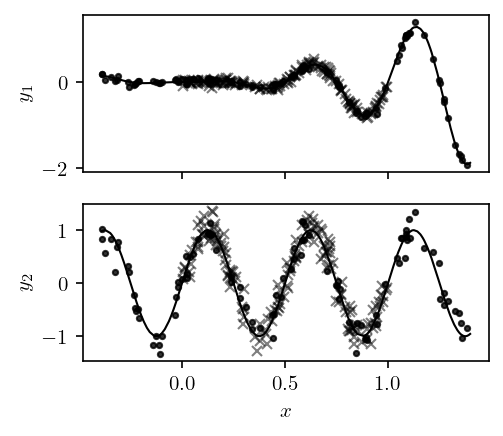

In [142]:
n_samples = 200
seed = 99

function_types = [1, 3]
sigma_noise = [5e-2, 2e-1]
n_channels = len(function_types)

train = tools.get_data(n_samples,[0,1], function_type=function_types, sigma=sigma_noise, dtype='float32', random_seed=seed)
test= tools.get_data(100, [-.4,1.4],   function_type=function_types, sigma=sigma_noise, dtype='float32', random_seed=seed)
true = tools.get_data(300, [-.4,1.4],  function_type=function_types, sigma=[0.,0.], dtype='float32')

train, val = tools.split(train, test_size=0.2)

# Create scaler from training data
scaler  = tools.Scaler(*train)

# Scale data (only required for testing purposes)
train_scaled = scaler.scale(*train)
val_scaled = scaler.scale(*val)
test_scaled = scaler.scale(*test)
true_scaled = scaler.scale(*true)



def get_figure(n_channels=n_channels):
    # Plot data
    fig, ax = plt.subplots(n_channels, 1, figsize=(3.49, 3.0),dpi=150, sharex=True)

    if n_channels == 1:
        ax = [ax]

    for i in range(n_channels):
        ax[i].plot(true[0], true[1][:,i], label='true', color='k')
        ax[i].plot(train[0], train[1][:,i], 'x', color='k', label=f'train', alpha=0.5)
        ax[i].plot(test[0], test[1][:,i], '.', color='k', label=f'test', alpha=0.8)

    ax[0].set_ylabel('$y_1$')
    ax[1].set_ylabel('$y_2$')
    ax[-1].set_xlabel('$x$')

    return fig, ax

fig, ax = get_figure()

# Keras model with Bayesian last layer
Generate a keras model and initialize a ``BayesianLastLayer`` instance.

In [143]:
# Fix seeds
def get_model():
    np.random.seed(seed)
    tf.random.set_seed(seed)

    model_input = keras.Input(shape=(train[0].shape[1],))

    # Hidden units
    architecture = [
    (keras.layers.Dense, {'units': 20, 'activation': tf.nn.tanh, 'name': '01_dense'}),
    (keras.layers.Dense, {'units': 20, 'activation': tf.nn.tanh, 'name': '02_dense'}),
    (keras.layers.Dense, {'units': 20, 'activation': tf.nn.tanh, 'name': '03_dense'}),
    (keras.layers.Dense, {'name': 'output', 'units': train[1].shape[1]})
    ]

    # Get layers and outputs:
    model_layers, model_outputs = tools.DNN_from_architecture(model_input, architecture)
    output_model = keras.Model(inputs=model_input, outputs=model_outputs[-1])
    joint_model = keras.Model(model_input, [model_outputs[-2], model_outputs[-1]])
    return joint_model, output_model

## Train the model with log-marginal-likelihood loss
Use Keras callbacks for early stopping


In [144]:
# Load model or create and train new model
save_name_bll = 'results/02_Multivariate_BLLModel01.pkl'
load_saved_model = True

if not load_saved_model:
    # Fix seeds
    np.random.seed(seed)
    tf.random.set_seed(seed)

    joint_model, _ = get_model()
    # Get bll model
    bllmodel = bll.BayesianLastLayer(joint_model, scaler)
    #Prepare training
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    #Setup training:
    bllmodel.setup_training(optimizer)
    # Get callback for early stopping
    cb_early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-5,
    patience=1000,
    verbose=True,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    )

    #Train
    bllmodel.fit(*train, val=val, epochs=10000, verbose=True, callbacks=[cb_early_stopping])

    bllmodel.save(save_name_bll, custom_objects={'sin': tf.math.sin})
else:
    # Unpickle
    with open(save_name_bll, 'rb') as f:
        bllmodel = pickle.load(f)

    joint_model = bllmodel.joint_model


Print information about trained bllmodel

In [145]:
print(bllmodel)

BayesianLastLayer
----------------
State:
- setup_training = False
- prepare_prediction = True
- n_x   = 1
- n_phi = 21
- n_y   = 2
Results:
- train_lml   = [-0.087]
- log_alpha   = [2.857]
- log_sigma_e = [-1.787 -1.37 ]



In [146]:
print(f'Noise sigma on data: {np.array(sigma_noise)}')
print(f'Estimated noise sigma: {tf.exp(bllmodel.log_sigma_e).numpy()*bllmodel.scaler.scaler_y.scale_}')

Noise sigma on data: [0.05 0.2 ]
Estimated noise sigma: [0.05070587 0.17855083]


Save scores for BLL:

In [147]:
%%capture

result_dict['LML feat']['LML']['alpha_star'].update({
'train': bllmodel.score(*train, scoring='lml'),
'test': bllmodel.score(*test, scoring='lml'),
})
result_dict['LML feat']['LPD']['alpha_star'].update({
'train': bllmodel.score(*train, scoring='lpd'),
'test': bllmodel.score(*test, scoring='lpd'),
})
result_dict['LML feat']['MSE'][' '].update({
'train': bllmodel.score(*train, scoring='mse'),
'test': bllmodel.score(*test, scoring='mse'),
})

## Test for better values of $\alpha$ and reset parameter

In [150]:
bll_log_alpha_test = bllmodel.grid_search_alpha(*test, rel_range=[-3,10], scores=['lml', 'lpd'], samples = 200, max_cond=1e8)
bll_log_alpha_train = bllmodel.grid_search_alpha(*train, rel_range=[-3,10],scores=['lml', 'lpd'], samples = 200, max_cond=1e8)

ind_alpha_max_bll = np.argmax(bll_log_alpha_test['lpd'])
alpha_max_bll = bll_log_alpha_test['log_alpha'][ind_alpha_max_bll]
alpha_opt_bll = bllmodel.log_alpha.numpy()

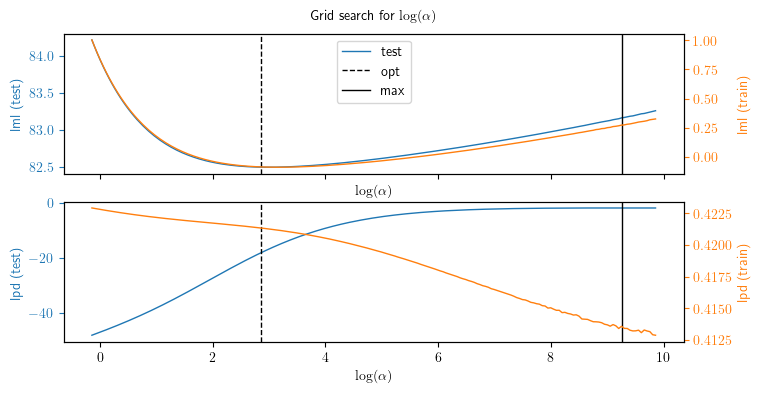

In [151]:

fig, ax = tools.plot_alpha_search(bll_log_alpha_train, bll_log_alpha_test, alpha_opt_bll, alpha_max_bll, figsize=(8,4), sharex=True)
fig.align_ylabels()

### Reset alpha and obtain updated KPI

In [152]:
bllmodel.log_alpha = alpha_max_bll

In [153]:
%%capture 

result_dict['LML feat']['LML']['alpha_max'].update({
    'train': bllmodel.score(*train, scoring='lml'),
    'test': bllmodel.score(*test, scoring='lml'),
})
result_dict['LML feat']['LPD']['alpha_max'].update({
    'train': bllmodel.score(*train, scoring='lpd'),
    'test': bllmodel.score(*test, scoring='lpd'),
})

### Predictive distribution for updated alpha in comparison with previous results

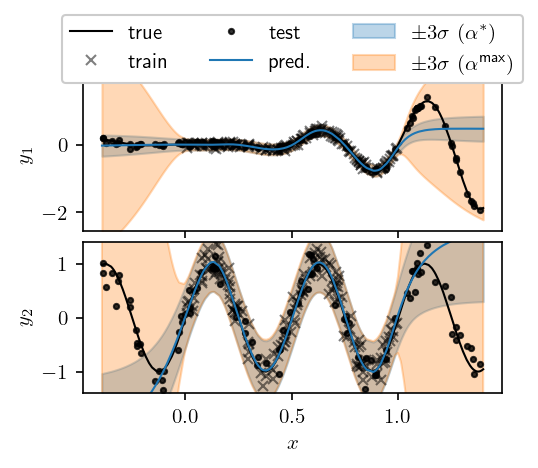

In [154]:
# Create prediction
y_pred, y_std_alpha_max = bllmodel.predict(true[0], uncert_type='std', with_noise_variance=True)

# Plus/minus 3 sigma:
p3sigma_alpha_max = (y_pred+3*y_std_alpha_max)
m3sigma_alpha_max = (y_pred-3*y_std_alpha_max)

# Get figure:
fig, ax = get_figure()

# Add to figure:
for i in range(n_channels):
    ax[i].plot(true[0], y_pred[:,i], '-', color=color[0], label='pred.')
    ax[i].fill_between(true[0].flatten(), m3sigma_alpha_star[:,i], p3sigma_alpha_star[:,i], alpha=0.3, label=r'$\pm 3\sigma$ $(\alpha^*)$', color=color[0])
    ax[i].fill_between(true[0].flatten(), m3sigma_alpha_max[:,i], p3sigma_alpha_max[:,i], alpha=0.3, label=r'$\pm 3\sigma$ $(\alpha^{\text{max}})$', color=color[1])

    data_min = np.min(true[1][:,i])
    data_max = np.max(true[1][:,i])
    data_range = data_max - data_min
    ax[i].set_ylim(data_min - .2*data_range, data_max + .2*data_range)

fig.align_ylabels()
legend = ax[0].legend(ncol=3, loc='upper center', bbox_to_anchor=(.5, 1.5), fancybox=True, framealpha=1)
fig.tight_layout(pad=0.2)

if export_figures:
    name = '07_Multivariate_LMLH.pgf'
    fig.savefig(f'{export_dir}{name}')

## BLR with trained NN (training with MSE)

In [155]:
# Load model or create and train new model
save_name_map = 'results/02_Multivariate_BLRModel01.pkl'
load_saved_model =  True

if not load_saved_model:
    # Get model
    joint_model_map, output_model_map = get_model()

    #Prepare training
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    output_model_map.compile(optimizer=optimizer, loss='mse', run_eagerly=True)

    # Callback for early stopping
    cb_early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=1e-5,
        patience=1000,
        verbose=True,
        mode="auto",
        baseline=None,
        restore_best_weights=True,
    )

    # Fit the output model 
    hist_map_model = output_model_map.fit(*train_scaled, batch_size=1000, validation_data=val_scaled, epochs=10000, verbose=0, callbacks=[cb_early_stopping])

    # Save the joint model
    joint_model_map.save(save_name_map)
else:
    joint_model_map = keras.models.load_model(save_name_map)
    hist_map_model = None

In [156]:
if hist_map_model:
    fig, ax = plt.subplots()

    ax.set_title('Training progression of the MAP model')
    ax.semilogy(hist_map_model.history['loss'], label='train')
    ax.semilogy(hist_map_model.history['val_loss'], label='val')
    ax.set_xlabel('epochs')
    ax.set_ylabel('loss (MSE)')
    ax.legend()


In [157]:
%%capture 

blr_map = bayli.BayesianLinearRegression(scale_x=True, scale_y=True, add_bias=True, estimate_covariance=False)

def feat_fun_map(x):
    phi, y_hat = joint_model_map(x)
    phi = phi.numpy()
    y_hat = y_hat.numpy() 
    return phi

blr_map.set_feature_function(feat_fun_map)


blr_map.fit(train[0], train[1])


In [158]:
%%capture

result_dict['MAP feat']['LML']['alpha_star'].update({
'train': blr_map.score(*train, scoring='lml'),
'test': blr_map.score(*test, scoring='lml'),
})
result_dict['MAP feat']['LPD']['alpha_star'].update({
'train': blr_map.score(*train, scoring='lpd'),
'test': blr_map.score(*test, scoring='lpd'),
})
result_dict['MAP feat']['MSE'][' '].update({
'train': blr_map.score(*train, scoring='mse'),
'test': blr_map.score(*test, scoring='mse'),
})

## Test for better values of $\alpha$ and reset parameter

In [159]:
%%capture
scores = ['lml', 'lpd']
blr_log_alpha_test = blr_map.grid_search_alpha(*test, rel_range=[-3, 10], samples=100, scores=scores)
blr_log_alpha_train = blr_map.grid_search_alpha(*train, rel_range=[-3, 10], samples=100, scores=scores)

In [160]:
ind_alpha_max_blr = np.argmax(blr_log_alpha_test['lpd'])
alpha_max_blr = blr_log_alpha_test['log_alpha'][ind_alpha_max_blr]
alpha_opt_blr = blr_map.log_alpha

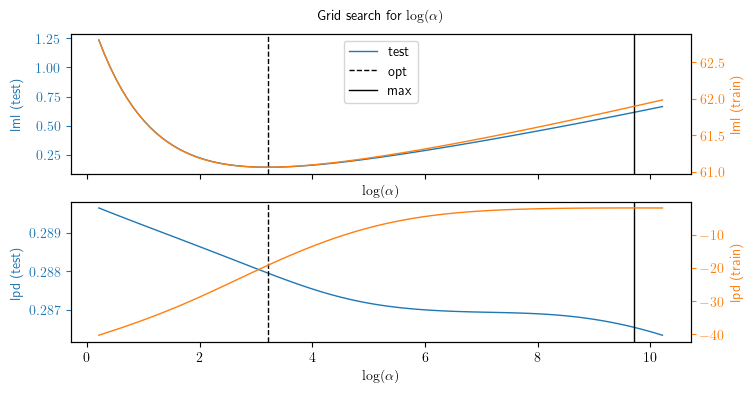

In [161]:
fig, ax = tools.plot_alpha_search(blr_log_alpha_test, blr_log_alpha_train, alpha_opt_blr, alpha_max_blr, figsize=(8,4), sharex=True)
fig.align_ylabels()

In [162]:
# Prediction with original alpha
y_pred_map, y_std_map = blr_map.predict(true[0], return_std=True, with_noise_variance=True)

# Update alpha
blr_map.log_alpha = alpha_max_blr

# Prediction with alpha_max
_ , y_std_map_alpha_max = blr_map.predict(true[0], return_std=True, with_noise_variance=True)

Save performance metrics

In [163]:
%%capture

result_dict['MAP feat']['LML']['alpha_max'].update({
    'train': blr_map.score(*train, scoring='lml'),
    'test': blr_map.score(*test, scoring='lml'),
})
result_dict['MAP feat']['LPD']['alpha_max'].update({
    'train': blr_map.score(*train, scoring='lpd'),
    'test': blr_map.score(*test, scoring='lpd'),
})

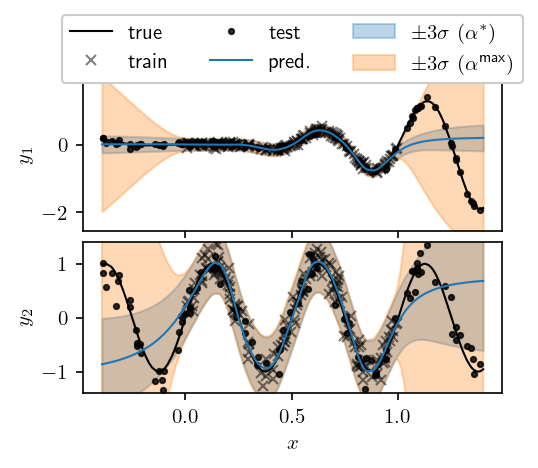

In [164]:
# Plus/minus 3 sigma:
p3sigma_alpha= (y_pred_map+3*y_std_map)
m3sigma_alpha= (y_pred_map-3*y_std_map)
p3sigma_alpha_max = (y_pred_map+3*y_std_map_alpha_max)
m3sigma_alpha_max = (y_pred_map-3*y_std_map_alpha_max)

# Get figure:
fig, ax = get_figure()

# Add to figure:
for i in range(n_channels):
    ax[i].plot(true[0], y_pred_map[:,i], '-', color=color[0], label='pred.')
    ax[i].fill_between(true[0].flatten(), m3sigma_alpha[:,i], p3sigma_alpha[:,i], alpha=0.3, label=r'$\pm 3\sigma$ $(\alpha^*)$', color=color[0])
    ax[i].fill_between(true[0].flatten(), m3sigma_alpha_max[:,i], p3sigma_alpha_max[:,i], alpha=0.3, label=r'$\pm 3\sigma$ $(\alpha^{\text{max}})$', color=color[1])

    data_min = np.min(true[1][:,i])
    data_max = np.max(true[1][:,i])
    data_range = data_max - data_min
    ax[i].set_ylim(data_min - .2*data_range, data_max + .2*data_range)

fig.align_ylabels()
legend = ax[0].legend(ncol=3, loc='upper center', bbox_to_anchor=(.5, 1.5), fancybox=True, framealpha=1)
fig.tight_layout(pad=0.2)

if export_figures:
    name = '07_Multivariate_MAP_features.pgf'
    fig.savefig(f'{export_dir}{name}')


# Create table with results and export to Latex

This creates Table 1 in the paper.

In [165]:
def dict2df(d, index_names=['LML feat', 'MAP feat'], max_depth = 2):
    df_list = []
    for key, value in d.items():
        if isinstance(value, dict) and max_depth > 0:
            df_k = dict2df(value, max_depth = max_depth-1)
        else:
            value = {key: np.array([val]).reshape(-1) for key, val in value.items()}
            df_k = pd.DataFrame({key: np.array(val) for key, val in value.items()})
        df_list.append(df_k)

    if list(d.keys()) == index_names:
        df = pd.concat(df_list, axis=0)
        df.index = index_names
    else:
        df = pd.concat(df_list, keys=d.keys(), axis=1)

    return df



df = dict2df(result_dict)
df

LML                                        LPD             \
         alpha_star            alpha_max            alpha_star              
              train       test     train       test      train       test   
LML feat  -0.087345  82.495758  0.271721  83.161461   0.421343 -18.144417   
MAP feat   0.144679  61.062109  0.615244  61.895271   0.287954 -19.200144   

                                   MSE            
         alpha_max                                
             train      test     train      test  
LML feat  0.413557 -1.825026  0.042178  2.982998  
MAP feat  0.286551 -1.954222  0.046967  2.201642

Modify exported Latex table

In [166]:
%%capture
tex_str = df.to_latex(
    float_format='{:0.2f}'.format,
    multicolumn=True,
    multirow=True,
    column_format='p{2.5cm}'+'X'*(len(df.columns)),
)

tex_str = tex_str.replace('tabular', 'tabularx')
tex_str = tex_str.replace('alpha\\_star', r'$\alpha^*$')
tex_str = tex_str.replace('alpha\\_max', r'$\alpha^{\text{max}}$')
tex_str = tex_str.replace('\\begin{tabularx}', '\\begin{tabularx}{\\textwidth}')
tex_str = tex_str.replace('LML feat', r'NN w. BLL')
tex_str = tex_str.replace('MAP feat', r'BLR w. NN features')


tex_str_list = tex_str.split('\n')
tex_str_list[2] = tex_str_list[2].replace('LPD', r'LPD ($\uparrow$ is better)')
tex_str_list[2] = tex_str_list[2].replace('LML', r'NLML ($\downarrow$ is better)')
tex_str_list[2] = tex_str_list[2].replace('MSE', r'MSE ($\downarrow$ is better)')


tex_str_list.insert(4, r'\cmidrule(lr){2-3} \cmidrule(lr){4-5} \cmidrule(lr){6-7} \cmidrule(lr){8-9} ')
tex_str_list.insert(3, r'\cmidrule(lr){2-5} \cmidrule(lr){6-9}\cmidrule(lr){10-11}')

tex_str_list.pop(1) # Remove toprule


tex_str =  '\n'.join(tex_str_list)

if False:
    path = './'
    with open(path.format('07_Multivariate_LML_LPD_MSE_comparison.tex'), 'w') as f:
        f.write(tex_str)

    